# Common geometric operations

This notebook consists of an introduction to common geometric operations of vector data in Python GIS ecosystem.

Geometric operations refer to a set of methods that can be used to process and analyze geometric features, like points, lines and polygons. In the context of geographic data analysis, these operations allow us, for instance, to ask questions about how two or more geographic objects relate to each other: Do they intersect, touch, or overlap? Are they adjacent to one another? How far apart are they?

In this notebook, multiple examples of common geometric manipulations will be shown. Data used will be the same as the previous notebook, the [census data track from Austin](https://github.com/Python-GIS-book/site/blob/master/source/part2/chapter-06/nb/data/Austin/austin_pop_2019.gpkg).

Let's prepare and read the file, once downloaded:

In [8]:
# Import required packages
from pathlib import Path
import geopandas as gpd

# Define the data path and read it
data_folder = Path("data", "Austin")
fp = data_folder / "austin_pop_density_2019.gpkg"

data = gpd.read_file(fp)
data.head()

,pop2019,tract,area_km2,pop_density_km2,geometry
0,6070.0,002422,4029.771797,1.506289,"POLYGON ((615643.487 3338728.496, 615645.477 3..."
1,2203.0,001751,1532.029989,1.437961,"POLYGON ((618576.586 3359381.053, 618614.33 33..."
2,7419.0,002411,3960.343857,1.873322,"POLYGON ((619200.163 3341784.654, 619270.849 3..."
3,4229.0,000401,2181.761674,1.938342,"POLYGON ((621623.757 3350508.165, 621656.294 3..."
4,4589.0,002313,2431.208488,1.887539,"POLYGON ((621630.247 3345130.744, 621717.926 3..."


The column of interest in this case is the geometry column, which contains the polygon geometries. Its data type is GeoSeries, and the individual geometries are ultimately shapely geometric objects (e.g. Point, LineString, Polygon), and we can use all of shapely’s tools for geometric manipulations directly via geopandas. 

In [9]:
# Check the kind of object of the column (polygons)
data["geometry"].head()

0    POLYGON ((615643.487 3338728.496, 615645.477 3...
1    POLYGON ((618576.586 3359381.053, 618614.33 33...
2    POLYGON ((619200.163 3341784.654, 619270.849 3...
3    POLYGON ((621623.757 3350508.165, 621656.294 3...
4    POLYGON ((621630.247 3345130.744, 621717.926 3...
Name: geometry, dtype: geometry

In [10]:
# Check data type of the geometry column
type(data["geometry"])

geopandas.geoseries.GeoSeries

Let’s first plot the original geometries. We can use the built-in *.plot()* function in geopandas to plot the geometries, and *matplotlib.pyplot* to turn off axis lines and labels:

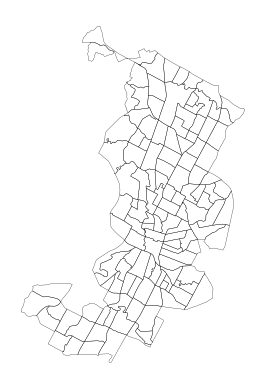

In [11]:
import matplotlib.pyplot as plt

data.plot(facecolor="none", linewidth=0.2)

plt.axis("off")
plt.show()

#### Centroid

The centroid of a geometry is the geometric center of a given geometry (line, polygon or a geometry collection). Extracting the centroid of geometric features is useful in many cases. For example, to locate text labels in visualizations. We can extract the center point of each polygon via the centroid attribute of the geometry column. 

The data should be in a projected coordinate reference system when calculating the centroids. If trying to calculate centroids based on latitude and longitude information, geopandas will warn us that the results are incorrect. 

In [ ]:
# Check the coordinate reference system (crs)
data.crs.name

'WGS 84 / UTM zone 14N'

In [13]:
# Check the centroids
data["geometry"].centroid.head()

0     POINT (616990.19 3339736.002)
1    POINT (619378.303 3359650.002)
2    POINT (620418.753 3342194.171)
3    POINT (622613.506 3351414.386)
4    POINT (622605.359 3343869.554)
dtype: geometry

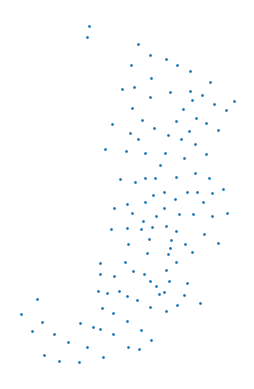

In [16]:
# Plot the centroids
data.centroid.plot(markersize=1)

plt.axis("off")
plt.show()